<a href="https://colab.research.google.com/github/probml/probml-notebooks/blob/main/notebooks/bnn_hierarchical_numpyro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hierarchical Bayesian Neural Networks

Illustration of hierarchial Bayesian neural network classifiers.
Code and text is based on [This blog post](https://twiecki.io/blog/2018/08/13/hierarchical_bayesian_neural_network/) by Thomas Wiecki.
[Original PyMC3 Notebook](https://github.com/twiecki/WhileMyMCMCGentlySamples/blob/master/content/downloads/notebooks/bayesian_neural_network_hierarchical.ipynb). Converted to Numpyro by Aleyna Kara (@karalleyna).


## Setup

In [2]:

# http://num.pyro.ai/en/stable/getting_started.html#installation
!pip install numpyro[cuda111] -f https://storage.googleapis.com/jax-releases/jax_releases.html


Looking in links: https://storage.googleapis.com/jax-releases/jax_releases.html
     |████████████████████████████████| 250 kB 4.1 MB/s 
     |████████████████████████████████| 197.0 MB 6.5 kB/s 
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.1.70+cuda110
    Uninstalling jaxlib-0.1.70+cuda110:
      Successfully uninstalled jaxlib-0.1.70+cuda110


In [4]:
import arviz as az

import argparse
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from jax import vmap
import jax.numpy as jnp
import jax.random as random

import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

from scipy import stats
import seaborn as sns
from warnings import filterwarnings

import sklearn
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

filterwarnings('ignore')
sns.set_style('white')

cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
cmap_uncertainty = sns.cubehelix_palette(light=1, as_cmap=True)

layer_names = ['w1_c', 'w2_c', 'w3_c']

## Data

The data set we are using are our battle tested half-moons as it is simple, non-linear and leads to pretty visualizations. This is what it looks like:

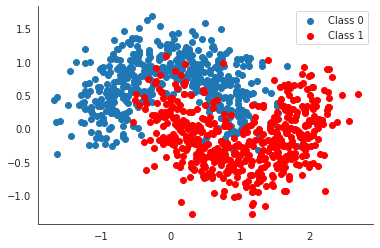

In [5]:
X, Y = make_moons(noise=0.3, n_samples=1000)
plt.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
plt.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); plt.legend();

This is just to illustrate what the data generating distribution looks like, we will use way fewer data points, and create different subsets with different rotations.

In [6]:
def rotate(X, deg):
    theta = np.radians(deg)
    c, s = np.cos(theta), np.sin(theta)
    R = np.matrix([[c, -s], [s, c]])

    X = X.dot(R)
    
    return np.asarray(X)

In [7]:
np.random.seed(31)

n_samples = 100
n_grps = 18
n_grps_sq = int(np.sqrt(n_grps))
Xs, Ys = [], []
for i in range(n_grps):
    # Generate data with 2 classes that are not linearly separable
    X, Y = make_moons(noise=0.3, n_samples=n_samples)
    X = scale(X)
    
    # Rotate the points randomly for each category
    rotate_by = np.random.randn() * 90.
    X = rotate(X, rotate_by)
    Xs.append(X)
    Ys.append(Y)

In [8]:
Xs = np.stack(Xs)
Ys = np.stack(Ys)

Xs_train = Xs[:, :n_samples // 2, :]
Xs_test = Xs[:, n_samples // 2:, :]
Ys_train = Ys[:, :n_samples // 2]
Ys_test = Ys[:, n_samples // 2:]

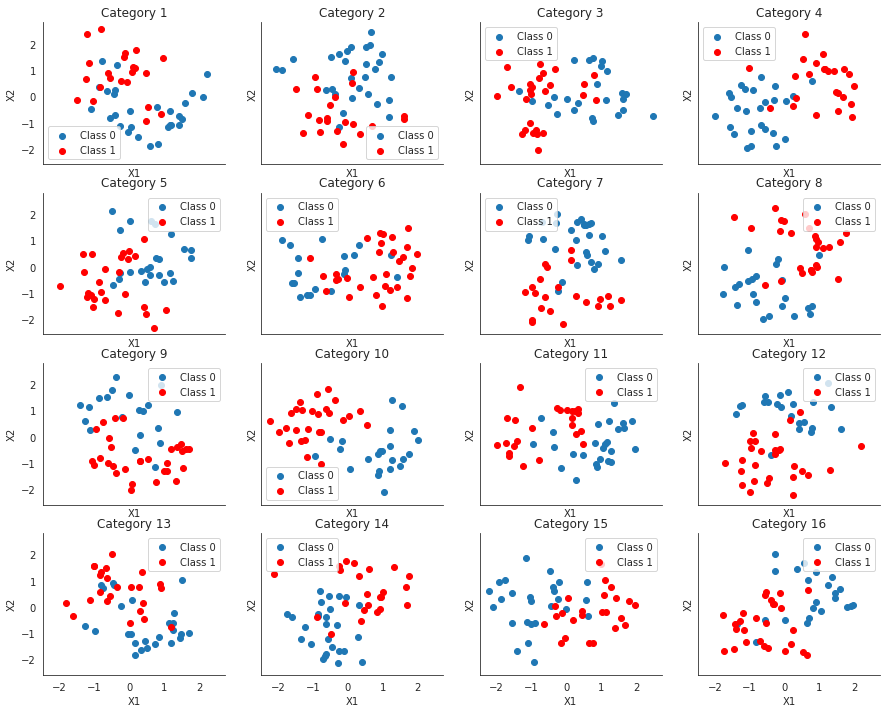

In [9]:
fig, axs = plt.subplots(figsize=(15, 12), nrows=n_grps_sq, ncols=n_grps_sq, 
                        sharex=True, sharey=True)
axs = axs.flatten()
for i, (X, Y, ax) in enumerate(zip(Xs_train, Ys_train, axs)):
    ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
    ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
    sns.despine(); ax.legend()
    ax.set(title='Category {}'.format(i + 1), xlabel='X1', ylabel='X2')

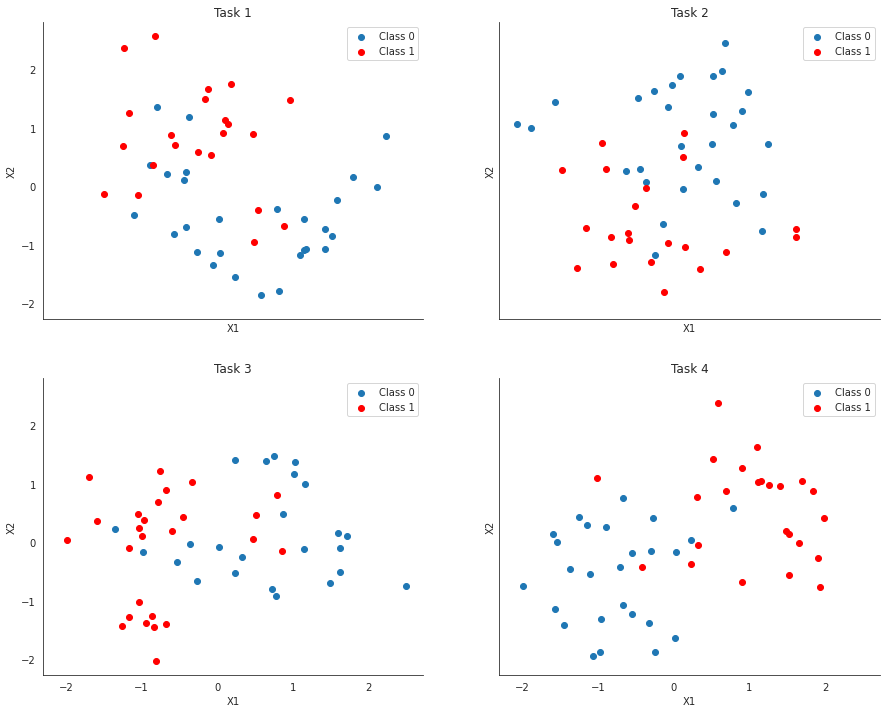

In [10]:
fig, axs = plt.subplots(figsize=(15, 12), nrows=2, ncols=2, 
                        sharex=True, sharey=True)
axs = axs.flatten()
for i, (X, Y, ax) in enumerate(zip(Xs_train, Ys_train, axs)):
    ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
    ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
    sns.despine(); ax.legend()
    ax.set(title='Task {}'.format(i + 1), xlabel='X1', ylabel='X2')

As you can see, we have 18 categories that share a higher-order structure (the half-moons). However, in the pure data space, no single classifier will be able to do a good job here. Also, because we only have 50 data points in each class, a NN will likely have a hard time producing robust results. But let's actually test this.

## Fit separate MLPs, one per task

First we fit one MLP per task/dataset. For details, see Thomas's blob post 
 on [Bayesian Deep Learning](https://twiecki.github.io/blog/2016/06/01/bayesian-deep-learning/).

In [11]:
'''
A two-layer bayesian neural network with computational flow
given by D_X => D_H => D_H => D_Y where D_H is the number of
hidden units.
'''
def model(X, Y, D_H):
    D_X, D_Y = X.shape[1], 1

    # sample first layer (we put unit normal priors on all weights)
    w1 = numpyro.sample("w1", dist.Normal(jnp.zeros((D_X, D_H)), jnp.ones((D_X, D_H))))  # D_X D_H
    z1 = jnp.tanh(jnp.matmul(X, w1))   # N D_H  <= first layer of activations

    # sample second layer
    w2 = numpyro.sample("w2", dist.Normal(jnp.zeros((D_H, D_H)), jnp.ones((D_H, D_H))))  # D_H D_H
    z2 = jnp.tanh(jnp.matmul(z1, w2))  # N D_H  <= second layer of activations
    
    # sample final layer of weights and neural network output
    w3 = numpyro.sample("w3", dist.Normal(jnp.zeros((D_H, D_Y)), jnp.ones((D_H, D_Y))))  # D_H D_Y
    z3 = jnp.matmul(z2, w3) # N D_Y  <= output of the neural network
    
    # Bernoulli likelihood <= Binary classification
    Y = numpyro.sample("Y", dist.Bernoulli(logits=z3))if Y is None else numpyro.sample("Y", dist.Bernoulli(logits=z3), obs=Y[:, None])

In [12]:
def run_inference(model, rng_key, args, **kwargs):
  kernel = NUTS(model)
  mcmc = MCMC(kernel, num_warmup=args["num_warmup"], num_samples=args["num_samples"], num_chains=args["num_chains"], progress_bar=False)
  mcmc.run(rng_key, **kwargs)
  return mcmc

In [13]:
def get_predictions(model, rng_key, samples, X, D_H, args, bnn_kwargs):
  # helper function for prediction
  def predict(model, rng_key, samples, X, D_H, bnn_kwargs):
      model = handlers.substitute(handlers.seed(model, rng_key), samples)
      # note that Y will be sampled in the model because we pass Y=None here
      model_trace = handlers.trace(model).get_trace(X=X, Y=None, D_H=D_H) if bnn_kwargs is None else handlers.trace(model).get_trace(X=X, Y=None, D_H=D_H, **bnn_kwargs)
      return model_trace['Y']['value']

  # predict Y at inputs X
  vmap_args = (samples, random.split(rng_key, args['num_samples']*args['num_chains']))
  predictions = vmap(lambda samples, rng_key: predict(model, rng_key, samples, X, D_H, bnn_kwargs))(*vmap_args)
  return predictions

In [14]:
def get_mean_predictions(predictions, threshold=0.5):
  predictions = predictions[..., 0]
  # compute mean prediction and confidence interval around median
  mean_prediction = jnp.mean(predictions, axis=0)
  return mean_prediction > threshold

In [15]:
def fit_and_eval(model, X_train, X_test, Y_train, Y_test, grid, D_H, args, bnn_kwargs=None):
  # values to be returned
  pred_train, pred_test, pred_grid = [], [], []

  # do inference
  kwargs = {"X": X_train, "Y": Y_train, "D_H": D_H}
  if bnn_kwargs:
    kwargs = {**kwargs, **bnn_kwargs}

  rng_key, rng_key_train, rng_key_test, rng_key_grid = random.split(random.PRNGKey(0), 4)
  mcmc = run_inference(model, rng_key, args, **kwargs)
  samples = mcmc.get_samples()
  
  # predict Y_train and Y_test at inputs X_traind and X_test, respectively
  predictions = get_predictions(model, rng_key_train, samples, X_train, D_H, args, bnn_kwargs)
  mean_prediction = get_mean_predictions(predictions)
  pred_train = mean_prediction
  
  predictions = get_predictions(model, rng_key_test, samples, X_test, D_H,  args, bnn_kwargs)
  mean_prediction = get_mean_predictions(predictions)
  pred_test = mean_prediction


  ppc_grid = get_predictions(model, rng_key_grid, samples, grid, D_H, args, bnn_kwargs)
  return pred_train, pred_test, ppc_grid, mcmc 

In [16]:
grid = np.mgrid[-3:3:100j, -3:3:100j].reshape((2, -1)).T
D_H = 5
args = {"num_samples": 500, "num_chains": 1, "num_warmup": 1000}

In [17]:
Ys_pred_train, Ys_pred_test, grid_eval= [], [], []

for X_train, Y_train, X_test, Y_test in zip(Xs_train, Ys_train, Xs_test, Ys_test): 
  pred_train, pred_test, ppc_grid, mcmc_flat = fit_and_eval(model, X_train, X_test, Y_train, Y_test, grid, D_H, args)
  Ys_pred_train.append(pred_train)
  Ys_pred_test.append(pred_test)
  grid_eval.append(ppc_grid)

KeyboardInterrupt: ignored

In [ ]:
Ys_pred_train = np.stack(Ys_pred_train)
Ys_pred_test = np.stack(Ys_pred_test)
ppc_grid_single = np.stack(grid_eval)

In [ ]:
print ("Train accuracy = {:.2f}%".format(100*np.mean(Ys_pred_train == Ys_train)))

Train accuracy = 86.67%


In [ ]:
print ("Test accuracy = {:.2f}%".format(100*np.mean(Ys_pred_test == Ys_test)))

Test accuracy = 83.56%


OK, that doesn't seem so bad. Now let's look at the decision surfaces -- i.e. what the classifier thinks about each point in the data space.

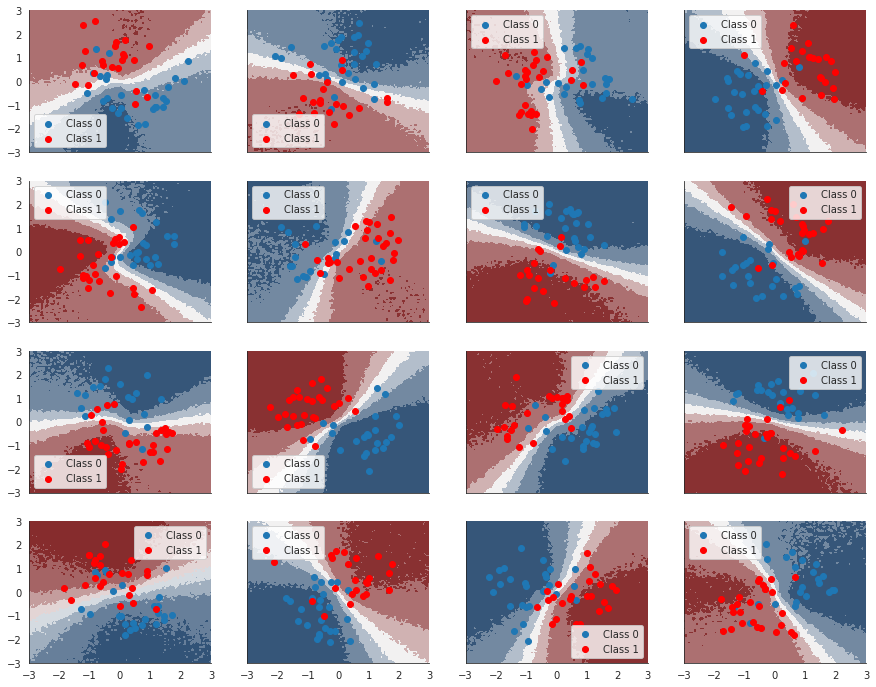

In [ ]:
fig, axs = plt.subplots(figsize=(15, 12), nrows=n_grps_sq, ncols=n_grps_sq, sharex=True, sharey=True)
axs = axs.flatten()
for i, (X, Y_pred, Y_true, ax) in enumerate(zip(Xs_train, Ys_pred_train, Ys_train, axs)):
    contour = ax.contourf(grid[:, 0].reshape(100, 100), grid[:, 1].reshape(100, 100), ppc_grid_single[i, ...].mean(axis=0).reshape(100, 100), cmap=cmap)
    ax.scatter(X[Y_true == 0, 0], X[Y_true == 0, 1], label='Class 0')
    ax.scatter(X[Y_true == 1, 0], X[Y_true == 1, 1], color='r', label='Class 1')
    sns.despine(); ax.legend()

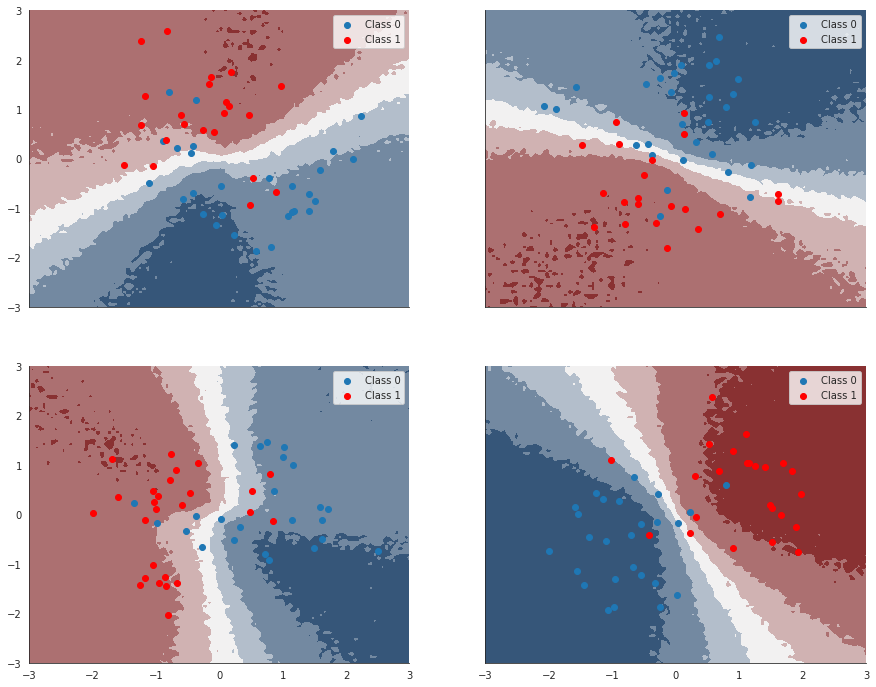

In [ ]:
fig, axs = plt.subplots(figsize=(15, 12), nrows=2, ncols=2, sharex=True, sharey=True)
axs = axs.flatten()
for i, (X, Y_pred, Y_true, ax) in enumerate(zip(Xs_train, Ys_pred_train, Ys_train, axs)):
    contour = ax.contourf(grid[:, 0].reshape(100, 100), grid[:, 1].reshape(100, 100), ppc_grid_single[i, ...].mean(axis=0).reshape(100, 100), cmap=cmap)
    ax.scatter(X[Y_true == 0, 0], X[Y_true == 0, 1], label='Class 0')
    ax.scatter(X[Y_true == 1, 0], X[Y_true == 1, 1], color='r', label='Class 1')
    sns.despine(); ax.legend()

That doens't look all that convincing. We know from the data generation process we should get  a "Z"-shaped decision surface, but we don't have enough data to properly estimate the non-linearity in every category.

## Hierarchical Bayesian Neural Network


It's actually quite straight-forward to turn this into one big hierarchical model for all categories, rather than many individual ones. Let's call the weight connecting neuron $i$ in layer 1 to neuron $j$ in layer 2 in category $c$ $w_{i, j, c}$ (I just omit the layer index for simplicity in notation). Rather than placing a fixed prior as we did above (i.e. $ w_{i, j, c} \sim \mathcal{N}(0, 1^2)$), we will assume that each weight comes from an overarching group distribution:
$ w_{i, j, c} \sim \mathcal{N}(\mu_{i, j}, \sigma^2)$. The key is that we will estimate $\mu_{i, j}$ and $\sigma$ simultaneously from data. 


Why not allow for different $\sigma_{i,j}^2$ per connection you might ask? Mainly just to make our life simpler and because it works well enough.

Note that we create a very rich model here. Every individual weight has its own hierarchical structure with a single group mean parameter and 16 per-category weights distributed around the group mean. While this creates a big amount of group distributions (as many as the flat NN had weights) there is no problem with this per-se, although it might be a bit unusual. One might argue that this model is quite complex and while that's true, in terms of degrees-of-freedom, this model is simpler than the unpooled one above (more on this below).

As for the code, we stack weights along a 3rd dimenson to get separate weights for each group. That way, through the power of broadcasting, the linear algebra works out almost the same as before.

In [ ]:
'''
A two-layer bayesian neural network with computational flow
given by D_X => D_H => D_H => D_Y where D_H is the number of
hidden units.
'''
def hierarchical_nn(X, Y, D_H):
    D_C, _, D_X = X.shape
    D_Y = 1

    # Group mean distribution for input to hidden layer
    w1_c = numpyro.sample("w1_c", dist.Normal(jnp.zeros((D_X, D_H)), jnp.ones((D_X, D_H))))  # D_X D_H
    # Group standard-deviation
    w1_c_std = numpyro.sample("w1_c_std", dist.HalfNormal(1.))

    # sample second layer
    w2_c = numpyro.sample("w2_c", dist.Normal(jnp.zeros((D_H, D_H)), jnp.ones((D_H, D_H))))  # D_H D_H
    w2_c_std = numpyro.sample("w2_c_std", dist.HalfNormal(1.))
    
    # sample final layer of weights and neural network output
    w3_c = numpyro.sample("w3_c", dist.Normal(jnp.zeros((D_H, D_Y)), jnp.ones((D_H, D_Y))))  # D_H D_Y
    w3_c_std = numpyro.sample("w3_c_std", dist.HalfNormal(1.))

    w1_all = numpyro.sample("w1_all", dist.Normal(jnp.zeros((D_C, D_X, D_H)), jnp.ones((D_C, D_X, D_H))))  # D_C D_X D_H
    w2_all = numpyro.sample("w2_all", dist.Normal(jnp.zeros((D_C, D_H, D_H)), jnp.ones((D_C, D_H, D_H))))  # D_C D_H D_H
    w3_all = numpyro.sample("w3_all", dist.Normal(jnp.zeros((D_C, D_H, D_Y)), jnp.ones((D_C, D_H, D_Y))))  # D_C D_H D_Y
    
    w1 = w1_all * w1_c_std + w1_c
    w2 = w2_all * w2_c_std + w2_c
    w3 = w3_all * w3_c_std + w3_c

    z1 = jnp.tanh(jnp.matmul(X, w1))   # D_C N D_H  <= first layer of activations    
    z2 = jnp.tanh(jnp.matmul(z1, w2))  # D_C N D_H  <= second layer of activations
    z3 = jnp.matmul(z2, w3) # D_C N D_Y  <= output of the neural network

    # Bernoulli likelihood <= Binary classification
    Y = numpyro.sample("Y", dist.Bernoulli(logits=z3), obs=Y.reshape((18, -1, 1)) if Y is not None else Y)

In [ ]:
# do inference
D_H = 5
# samples are 4000
args = {"num_samples": 500, "num_chains": 1, "num_warmup": 1000}
grid_3d = np.repeat(grid[None, ...], n_grps, axis=0)

In [ ]:
Ys_hierarchical_pred_train, Ys_hierarchical_pred_test, ppc_grid, mcmc_hier  =\
                            fit_and_eval(hierarchical_nn, Xs_train, Xs_test, Ys_train, Ys_test, grid_3d, D_H, args)
trace_hier = mcmc_hier.get_samples()

In [ ]:
print('Train accuracy = {:.2f}%'.format(100*np.mean(Ys_hierarchical_pred_train == Ys_train)))

Train accuracy = 90.78%


In [ ]:
print('Test accuracy = {:.2f}%'.format(100*np.mean(Ys_hierarchical_pred_test == Ys_test)))

Test accuracy = 89.33%


Great -- we get higher train *and* test accuracy. Let's look at what the classifier has learned for each category.

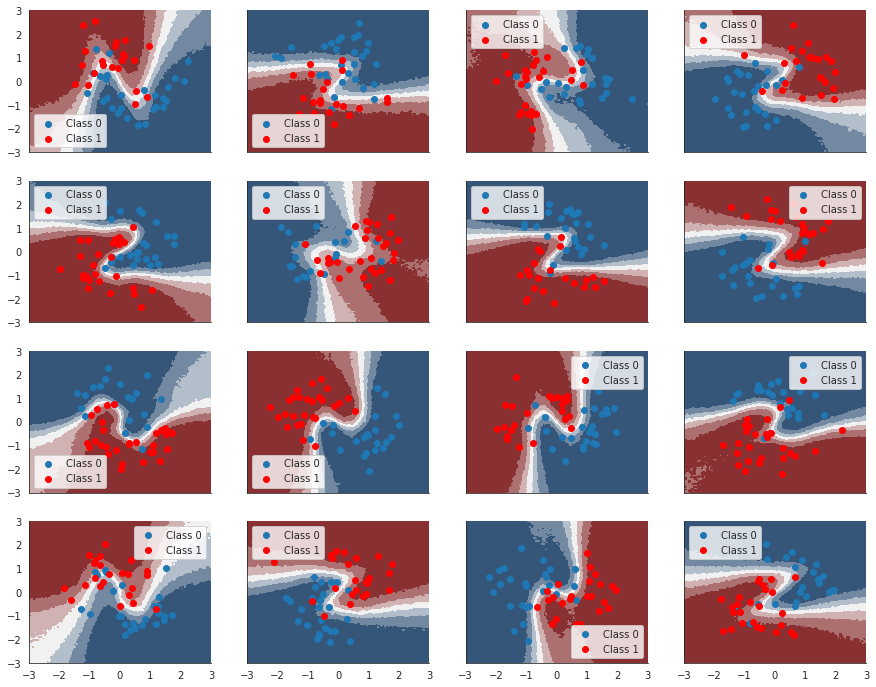

In [ ]:
fig, axs = plt.subplots(figsize=(15, 12), nrows=n_grps_sq, ncols=n_grps_sq, sharex=True, sharey=True)
axs = axs.flatten()
for i, (X, Y_pred, Y_true, ax) in enumerate(zip(Xs_train, Ys_hierarchical_pred_train, Ys_train, axs)):
    contour = ax.contourf(grid[:, 0].reshape((100, 100)), grid[:, 1].reshape((100, 100)), ppc_grid[:, i, :].mean(axis=0).reshape(100, 100), cmap=cmap)
    ax.scatter(X[Y_true == 0, 0], X[Y_true == 0, 1], label='Class 0')
    ax.scatter(X[Y_true == 1, 0], X[Y_true == 1, 1], color='r', label='Class 1')
    sns.despine(); ax.legend()

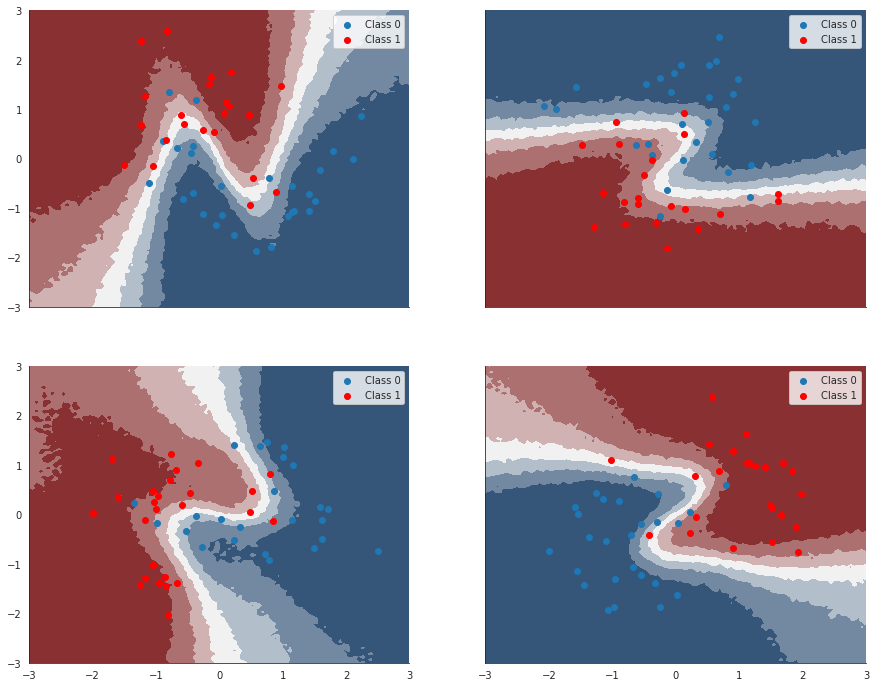

In [ ]:
fig, axs = plt.subplots(figsize=(15, 12), nrows=2, ncols=2, sharex=True, sharey=True)
axs = axs.flatten()
for i, (X, Y_pred, Y_true, ax) in enumerate(zip(Xs_train, Ys_hierarchical_pred_train, Ys_train, axs)):
    contour = ax.contourf(grid[:, 0].reshape((100, 100)), grid[:, 1].reshape((100, 100)), ppc_grid[:, i, :].mean(axis=0).reshape(100, 100), cmap=cmap)
    ax.scatter(X[Y_true == 0, 0], X[Y_true == 0, 1], label='Class 0')
    ax.scatter(X[Y_true == 1, 0], X[Y_true == 1, 1], color='r', label='Class 1')
    sns.despine(); ax.legend()
plt.show()